# Testing the 'Flow Matching in 100 LOC'-code and augmenting it with Bayesian Methods

In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Normal

import sys
sys.path.append('./models/')

from cond_CFM import CNF, FlowMatchingLoss

import numpy as np
import normflows as nf
import os
from tqdm import tqdm
from typing import *
from zuko.utils import odeint
from models.custom_linear_flipout import custom_LinearFlipout as LinearFlipout

from matplotlib import pyplot as plt

from jet_dataset import JetDataset

from typing import *
from zuko.utils import odeint

from sklearn.metrics import roc_curve, auc

In [2]:
def smooth(x, kernel_size=5):
    if kernel_size == 1:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out #np.mean(np.array(x).reshape(-1, kernel_size),1)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
save_dir = './data/CFM_jets6/'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [5]:
#######################
### Define the data ###
#######################

batch_size = 131072

dont_use = ['jet_sdmass', 
            'jet_tau1',	'jet_tau2',	'jet_tau3',	'jet_tau4',
            'aux_genpart_eta', 'aux_genpart_phi', 'aux_genpart_pid', 'aux_genpart_pt', 'aux_truth_match']

dataset = JetDataset("./jet_data",'train', del_context=dont_use)
dataset_val = JetDataset("./jet_data",'val', del_context=dont_use)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=10, pin_memory=True, persistent_workers=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=10, pin_memory=True, persistent_workers=True)

In [6]:
########################
### Define the Model ###
########################

model = CNF(1, conds = dataset.features.shape[1], n_nodes=[64] * 3).to(device)

loaded model from ./data/CFM_jets6/model_4000.pth


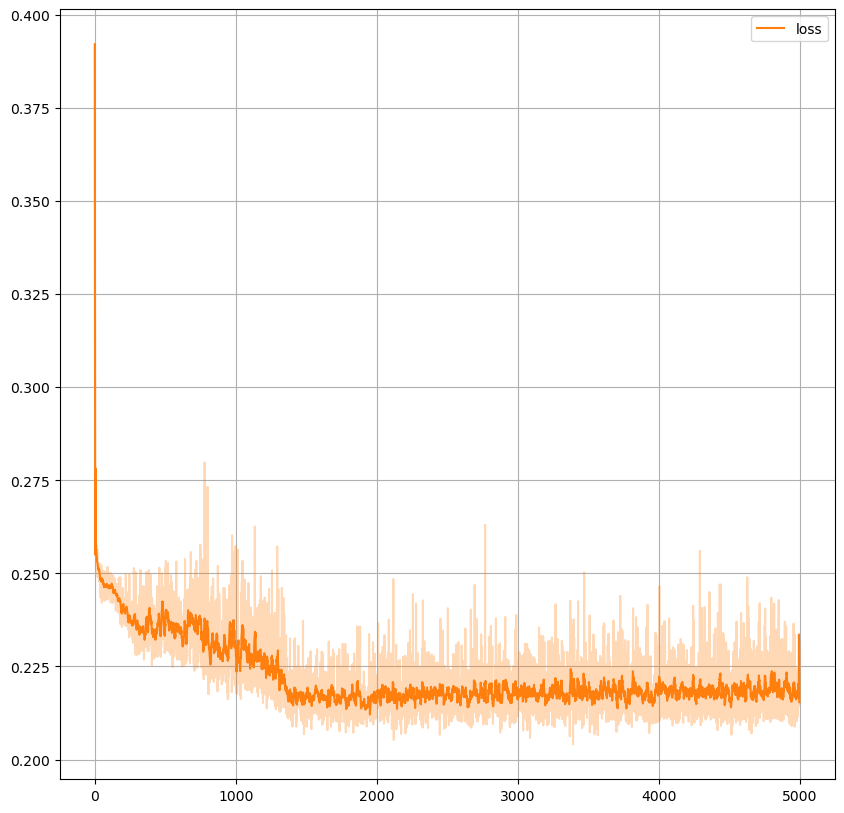

In [7]:
#####################
### Training Loop ###
#####################

train = False
lr = 1e-2
weight_decay = 0 
lr_decay = 1 #0.999

epochs = 5000

if train:
    cfm_loss = FlowMatchingLoss(model)
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, lr_decay)
    model.train()

    loss_hist = np.array([])

    for ep in tqdm(range(epochs)):
        optim.zero_grad()
        
        for x, c in dataloader:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            
            # Compute loss
            loss = cfm_loss(x, c)
            kl_loss = torch.nan_to_num(torch.sum(torch.tensor([layer.kl_loss() for layer in model.modules() 
                                                                if isinstance(layer, LinearFlipout)],  device=device))/len(x))
            
            loss = loss + c_factor*kl_loss

            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optim.step()
                scheduler.step()
            
        # Log loss
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

        if ep%50 == 0:
            torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")

    with open(save_dir + f'losses_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist)


# # Sampling
# with torch.no_grad():
# z = torch.randn(4096, 2)
# x = flow.decode(z).numpy()


# # Log-likelihood
# with torch.no_grad():
# log_p = flow.log_prob(data[:4])

    model.eval()

    torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")
    print('saved model at ' + save_dir + f"model_{ep}.pth")

else:
    ep = epochs-1

    with open(save_dir + f'losses_{ep}.npy', 'rb') as f:
        loss_hist = np.load(f)

    ep = 4000 #1500
    model.load_state_dict(torch.load(save_dir + f"model_{ep}.pth"))
    print('loaded model from ' + save_dir + f"model_{ep}.pth")

    model.eval()


# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(smooth(loss_hist,1), color = 'C1', alpha = 0.3)
plt.plot(smooth(loss_hist,11), label='loss', color = 'C1')
plt.grid()
plt.legend()
#plt.xlim(0,12500)
#plt.ylim(0,1)
img_outfile = save_dir + f"image_ep{ep}_loss.png"
plt.savefig(img_outfile)
plt.show()

In [48]:
print(sum(p.numel() for p in model.parameters()))

31617


loaded model from ./data/CFM_jets6/model_4000.pth


  0%|          | 0/1 [00:00<?, ?it/s]100%|██████████| 1/1 [00:09<00:00,  9.34s/it]


plotting rocs


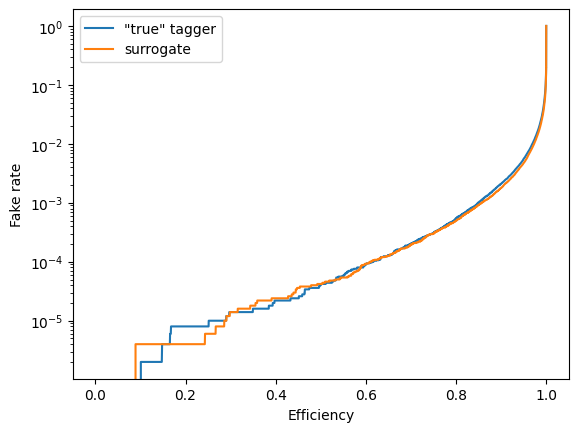

plotting raw (1000000, 1) torch.Size([1000000, 1])
plotting raw gen


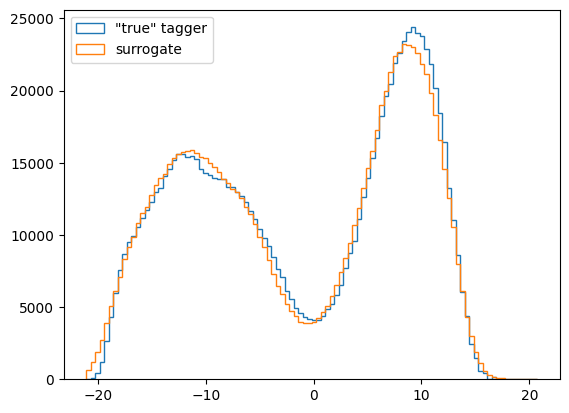

saved images at ./data/CFM_jets6/


In [76]:
################
### Plotting ###
################

#for ep in [ep]:
model.load_state_dict(torch.load(save_dir + f"model_{ep}.pth"))
print('loaded model from ' + save_dir + f"model_{ep}.pth")

model.eval()

n_stat = 1

with torch.no_grad():
    # get a batch to compare
    conditions = torch.Tensor(dataset_val.features).to(device)
    d = torch.Tensor(dataset_val.features).to(device)
    z = torch.randn(len(d), 1).to(device)

    x_gen_tmp = torch.ones(len(d), 1, n_stat)
    for n in tqdm(range(n_stat)):
        x_gen_tmp[:,:,n] = model.decode(z, cond=d).detach()

    x_gen_raw = x_gen_tmp.mean(2)
    conditions = dataset_val.features
    x_gen = x_gen_raw
    x_gen = x_gen*20. #back to full scale
    x_gen_raw = x_gen #HIER SOLLTE NOCH GEMITTELT WERDEN ÜBER OUTPUTS ZUR SELBEN CONDITION
    x_gen = torch.sigmoid(x_gen)
    print("plotting rocs")
    fpr,tpr,_ = roc_curve(dataset_val.truth, dataset_val.raw_target)
    gfpr,gtpr,_ = roc_curve(dataset_val.truth, x_gen.cpu())
    plt.plot(tpr, fpr, label='"true" tagger')
    plt.plot(gtpr, gfpr, label='surrogate')
    plt.xlabel("Efficiency")
    plt.ylabel("Fake rate")
    plt.legend()
    img_outfile = save_dir + f"image_ep{ep}.png"
    plt.savefig(img_outfile)

    plt.yscale('log')
    img_outfile = save_dir + f"image_ep{ep}_log.png"
    plt.savefig(img_outfile)
    plt.show()

    print("plotting raw", dataset_val.target.shape, x_gen_raw.shape)
    _,b,_ = plt.hist(dataset_val.target[:,0]*20.,bins=100, label='"true" tagger',histtype='step')
    print("plotting raw gen")
    plt.hist(x_gen_raw.cpu().numpy()[:,0],bins=b, label='surrogate',histtype='step')
    plt.legend()
    img_outfile = save_dir + f"image_ep{ep}_raw.png"
    plt.savefig(img_outfile)
    plt.show()
    print('saved images at ' + save_dir)

# Run AdamMCMC

In [8]:
sys.path.append('../MCMC_by_backprob/src/')
from MCMC_Adam import MCMC_by_bp

from time import time

In [28]:
model.load_state_dict(torch.load(save_dir + f"model_4000.pth"))

m_list_dir =  save_dir + '/AdamMCMC_models_test_lambda01/'

if not os.path.exists(m_list_dir):
    os.mkdir(m_list_dir)

MCMC_epochs = 1

lr = 5e-6

temp = 50
sigma = .05

loop_kwargs = {
             'MH': True, #this is a little more than x2 runtime
             'verbose': False,
             'sigma_adam_dir': 1*sigma, #not sure this helps
}

optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.99,0.999))
model.device = device

AdamMCMC = MCMC_by_bp(model, optim, temp, sigma)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, lr_decay)
model.train()

loss_hist, acc_hist, b_hist = np.array([]), np.array([]), np.array([])
maxed_out_mbb_batches = 0

for ep in range(MCMC_epochs):
    optim.zero_grad()
    
    i = 0
    for x, c in tqdm(dataloader):
        optim.zero_grad()
        x = x.to(device)
        c = c.to(device)
        
        # Compute log Likl
        loss = lambda: -torch.mean(model.log_prob(x,c))

        # Do backprop and optimizer step
        #t1= time()
        maxed_out_mbb_batches += 1
        _,a,b,sigma,stop_dict = AdamMCMC.step(loss, **loop_kwargs)
        #print(f't_update: {time()-t1:4.4} s')
        
        if b: 
            maxed_out_mbb_batches  = 0
        if maxed_out_mbb_batches > 100:
            print('MBB sampling is not convergent, reinitializing the chain')
            AdamMCMC.start = True #This is a hot fix to not get the optimizer stuck to often

        scheduler.step()
        acc_hist = np.append(acc_hist, a.to('cpu').data.numpy())
        b_hist = np.append(b_hist, b)

        if loop_kwargs['verbose']:
            i+=1
            if i == 3:
                break
        
    # Log loss
    loss_hist = np.append(loss_hist, loss().to('cpu').data.numpy())

    torch.save(model.state_dict(), m_list_dir + f"AdamMCMC_model_{ep}.pth")

with open(save_dir + f'AdamMCMC_losses_{ep}.npy', 'wb') as f:
    np.save(f, loss_hist)

  0%|          | 0/31 [00:03<?, ?it/s]


KeyboardInterrupt: 

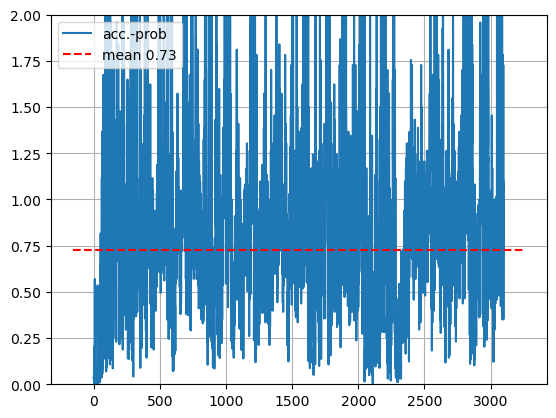

In [16]:
m_list_dir =  save_dir + '/AdamMCMC_models_lambda001/'

with open(m_list_dir + f'AdamMCMC_acc_99.npy', 'rb') as f:
    acc_hist = np.load(f)
    
plt.plot(acc_hist, label = 'acc.-prob')
plt.hlines(np.clip(acc_hist, 0, 1).mean(), *plt.xlim(), color = 'red', linestyles='--', label = f'mean {np.clip(acc_hist, 0, 1).mean():3.2}')
plt.grid()
plt.ylim(0,2)
plt.legend()
plt.savefig(m_list_dir+'acc.pdf')

100%|██████████| 101/101 [00:34<00:00,  2.97it/s]


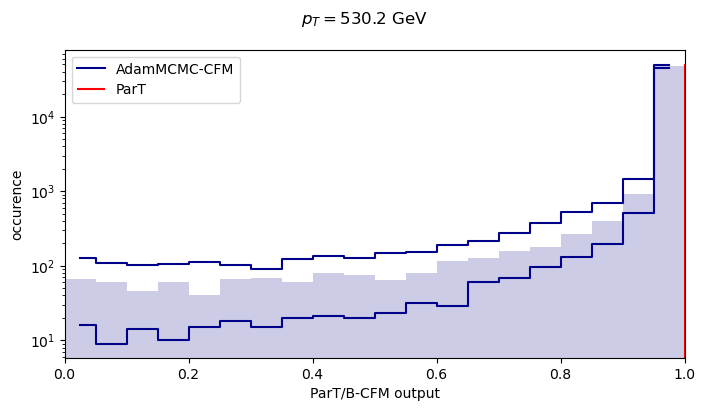

100%|██████████| 101/101 [00:32<00:00,  3.10it/s]


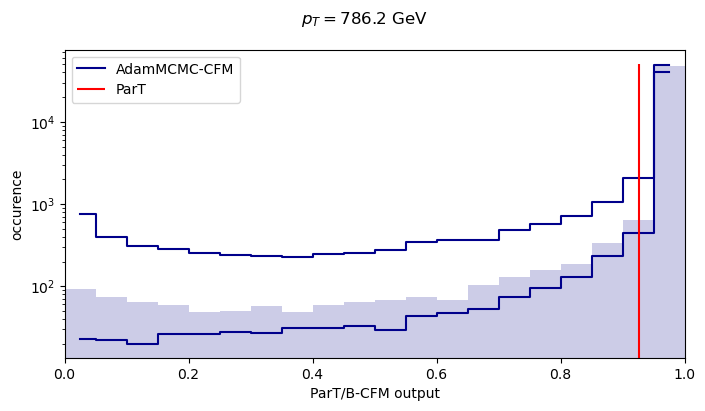

100%|██████████| 101/101 [00:32<00:00,  3.07it/s]


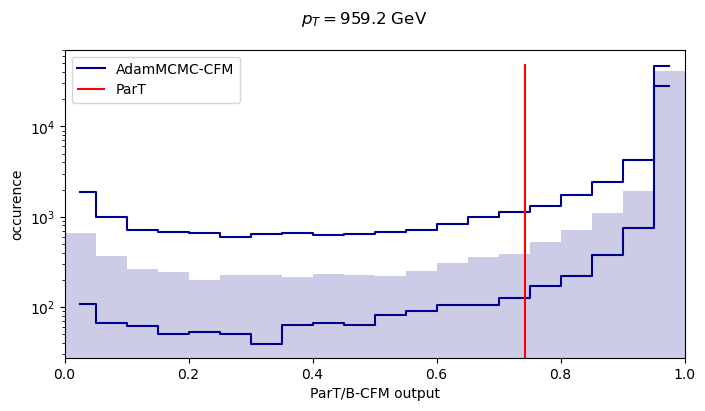

100%|██████████| 101/101 [00:25<00:00,  4.02it/s]


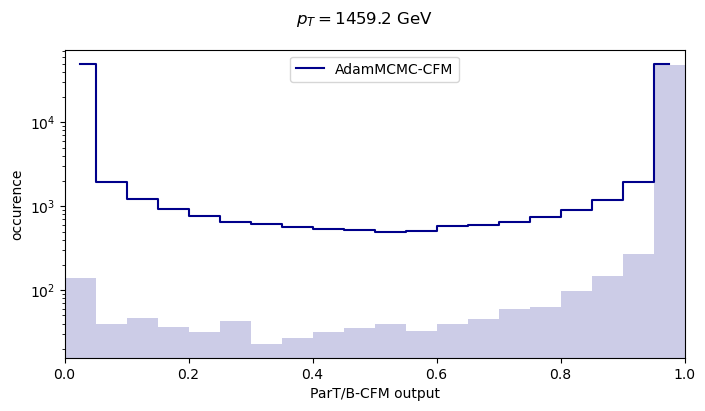

100%|██████████| 101/101 [00:33<00:00,  2.98it/s]


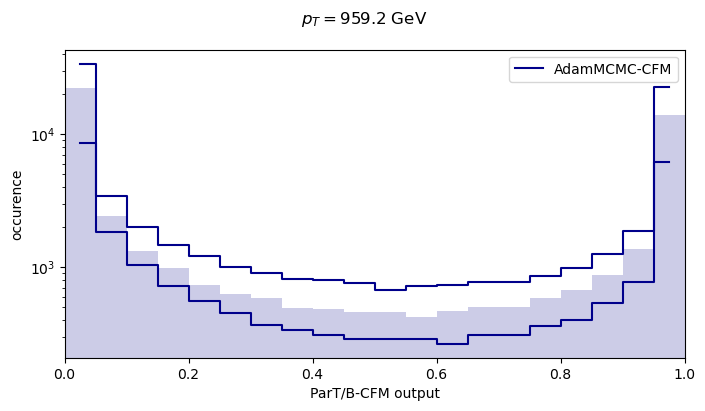

100%|██████████| 101/101 [00:34<00:00,  2.90it/s]


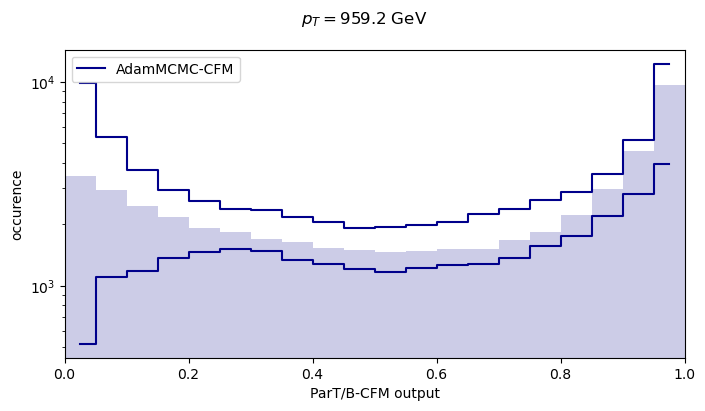

In [17]:
sort = np.argsort(dataset_val.features[:,1])
bins = np.linspace(0,1,21)

#m_list_dir =  save_dir + '/AdamMCMC_models_test_sum/'
m_list = [l for l in os.listdir(m_list_dir) if 'model' in l]
n_stat = len(m_list)+1
n_stat_alea = 50000

for event in [200003, -100005, -10000, 'pt', 'E', 'n']:
    if isinstance(event, str):
        k = -10000
    else:
        k = event
    fig,ax = plt.subplots(1,1, figsize = (8,4), sharex = True)#gridspec_kw={'height_ratios': [2,1], 'hspace': 0.})
    ax = [ax]
    i = sort[k]
    conditions = torch.Tensor(dataset_val.features).to(device)
    c = conditions[i:i+1]

    if event == 'pt':
        c[:,1] = (c[:,1]*dataset_val.std_norm[0,1]+500)/dataset_val.std_norm[0,1]
        
    elif event == 'E':
        c[:,4] = (c[:,4]*dataset_val.std_norm[0,4]+3500)/dataset_val.std_norm[0,4]

    elif event == 'n':
        c[:,5] = (c[:,5]*dataset_val.std_norm[0,5]+100)/dataset_val.std_norm[0,5]

    hists = []
    x_gens = []
    z = torch.randn(n_stat_alea, 1).to(device)

    for n in tqdm(range(n_stat)):

        if n==0:
            model.load_state_dict(torch.load(save_dir + f"model_4000.pth"))
        else:
            model.load_state_dict(torch.load(m_list_dir + m_list[n-1]))
            #print('loaded model from ' + m_list_dir + m_list[n-1])

        x_gen = model.decode(z, cond=c.repeat_interleave(n_stat_alea, dim=0))
        
        x_gen = torch.sigmoid(x_gen*20).detach().cpu().numpy()
        #x_gen = (x_gen*20).detach().cpu().numpy()
        x_gens.append(x_gen)
        hist, _ = np.histogram(x_gen, bins = bins)
        hists.append(hist)
    
    x_gens = np.array(x_gens)
    hists = np.array(hists)
    hist_max = hists.max(0)
    hist_min = hists.min(0)

    hist_orig,b,_ = ax[0].hist(x_gens[0],  bins = bins, color='darkblue', alpha=0.2)
    
    bincentres = [(b[i]+b[i+1])/2. for i in range(len(b)-1)]
    ax[0].step(bincentres, hist_max, where='mid',color='darkblue', label=f'AdamMCMC-CFM')
    ax[0].step(bincentres, hist_min, where='mid',color='darkblue')
    if not isinstance(event, str):
        ax[0].vlines(torch.sigmoid(torch.Tensor(dataset_val.target)[i,0]*20).numpy(), *ax[0].get_ylim(), color = 'red', label = 'ParT')

    #alpha = 0.95
    #quants = np.quantile(x_gens, 1-alpha, axis=1)
    #ax[0].vlines(np.quantile(x_gens.mean(0), 1-alpha), *ax[0].get_ylim(), color = 'red')
    #ax[0].vlines([quants.max(0), quants.min(0)], *ax[0].get_ylim(), color = 'red', linestyle='--')

    ax[0].set_ylabel('occurence')
   #ax[0].set_xlabel(r'$\mathrm{sig}^{-1}$ (ParT/B-CFM output)')
    ax[0].set_xlabel('ParT/B-CFM output')
    ax[0].set_yscale('log')
    ax[0].legend()
    ax[0].set_xlim(0,1)

    out_pt = c[0,1]*dataset_val.std_norm[0,1]+dataset_val.means_norm[0,1]
    fig.suptitle(r'$p_T =$' + f'{out_pt:4.1f} GeV')
    plt.savefig(m_list_dir + f'out_{i}_{event}_hmc.pdf')
    plt.show()

    #report the quantile value including uncertainty?

In [18]:
x_gens.shape

(101, 50000, 1)

# ROC curve eval

In [19]:
def alea_roc_curve(x_true, x_gen, treshholds = np.linspace(0,1,500)):
    '''
    x_true.shape: (N_jets)
    x_gen.shape: (N_jets, n_stat_alea, n_stat_epis)
    '''
    N_jets = len(x_true)
    assert N_jets == len(x_gen)
    n_stat_alea = x_gen.shape[1]
    n_stat_epis = x_gen.shape[2]

    tpr, fpr = np.zeros((len(treshholds), n_stat_epis)), np.zeros((len(treshholds), n_stat_epis))

    for i,t in tqdm(enumerate(treshholds)):
        label = x_gen >= t
        pos_ratio = np.sum(label, 1)/n_stat_alea
        neg_ratio = 1- pos_ratio #np.sum(label==0, 1)/n_stat_alea

        trues = x_true[:,0]==1
        falses = x_true[:,0]==0

        tp = np.sum(pos_ratio[trues], axis=0)
        fp = np.sum(pos_ratio[falses], axis=0)
        tn = np.sum(neg_ratio[falses], axis=0)
        fn = np.sum(neg_ratio[trues], axis=0)

        tpr[i] = tp/(tp+fn)
        fpr[i] = fp/(fp+tn)

    return fpr, tpr, treshholds

In [20]:
### plot the ROC curve including aleatoric uncertainty with epistemic envelopes ###

eval = True

#c_factor = 100
#save_dir = f'./data/CFM_VIB_k{c_factor}_jets6/'

n_stat_epis = n_stat
n_stat_alea = 1
batchsize = 50000
n_points = 50000


bins = np.linspace(0,1,21)
np.random.seed(0)
perm = np.random.permutation(len(dataset_val.features))
sort = np.argsort(dataset_val.features[:,1])

if eval:
    for start in [None, 200000, -100000, -n_points-1]:
        if start is None:
            dat = dataset_val.features[perm[:n_points]]
        else:
            dat = dataset_val.features[sort[start:start+n_points]]

        x_gens = np.zeros((n_points, n_stat_alea, n_stat))

        for k in tqdm(range(len(dat)//batchsize)):

            z = torch.randn(n_stat_alea*batchsize, 1).to(device)
            c = torch.Tensor(dat[k*batchsize:(k+1)*batchsize]).to(device)
            c = c.repeat_interleave(n_stat_alea, dim=0)

            for j in range(n_stat):
                if j==0:
                    model.load_state_dict(torch.load(save_dir + f"model_4000.pth"))
                else:
                    model.load_state_dict(torch.load(m_list_dir + m_list[j-1]))
                    #print('loaded model from ' + m_list_dir + m_list[n-1])

                x_gen = model.decode(z, cond=c)
                x_gens[k*batchsize:(k+1)*batchsize, :, j] = torch.sigmoid(x_gen*20).detach().cpu().numpy().reshape(batchsize, n_stat_alea)

        save_str = m_list_dir + 'x_gens'
        if start is not None:
            save_str += f'_{start}_{start+n_points}'
        save_str += '.npy'
        
        with open(save_str, 'wb') as f:
            np.save(f, x_gens)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:55<00:00, 55.34s/it]


calculating: None


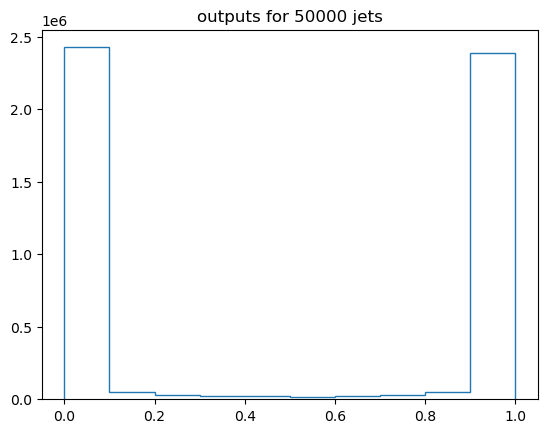

4620it [07:16, 10.59it/s]


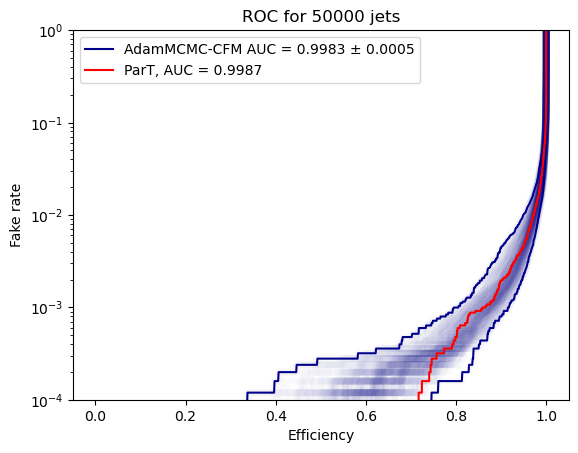

calculating: 200000


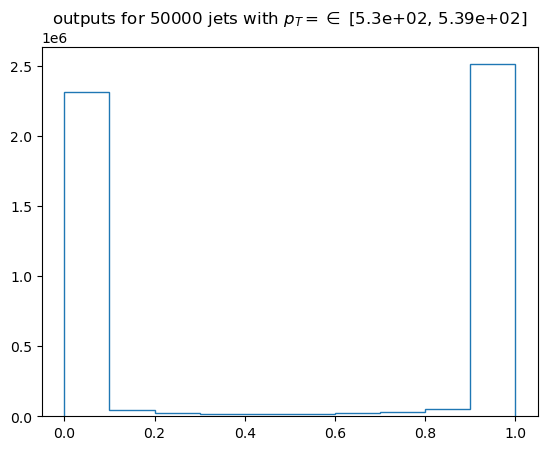

4756it [07:29, 10.58it/s]


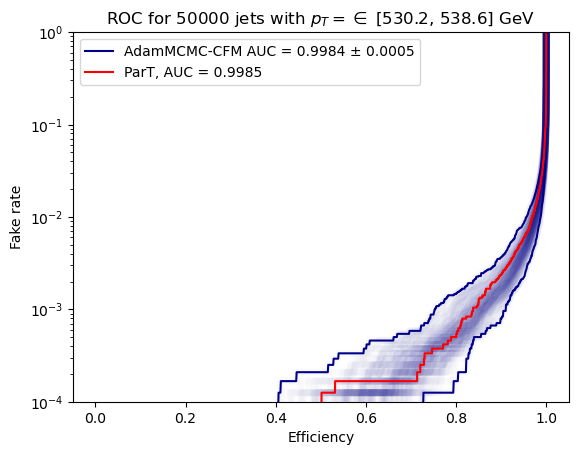

calculating: -100000


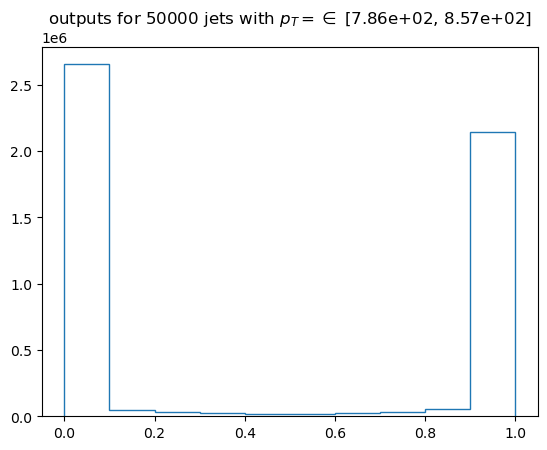

4300it [06:47, 10.55it/s]


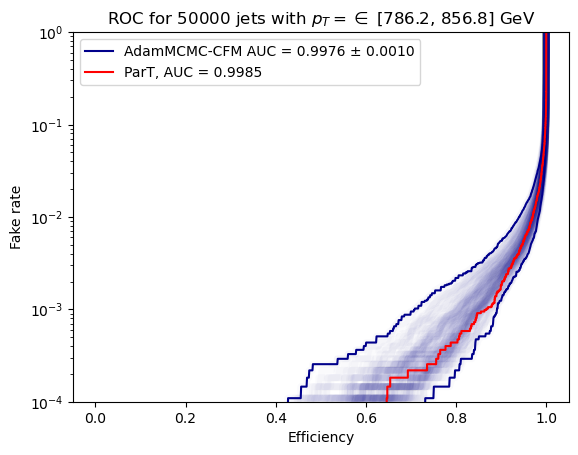

calculating: -50001


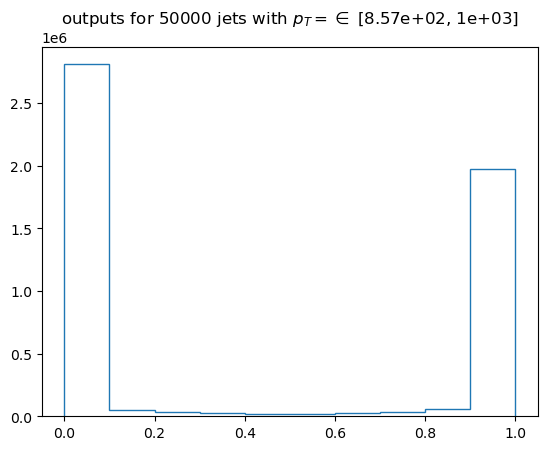

4143it [06:24, 10.78it/s]


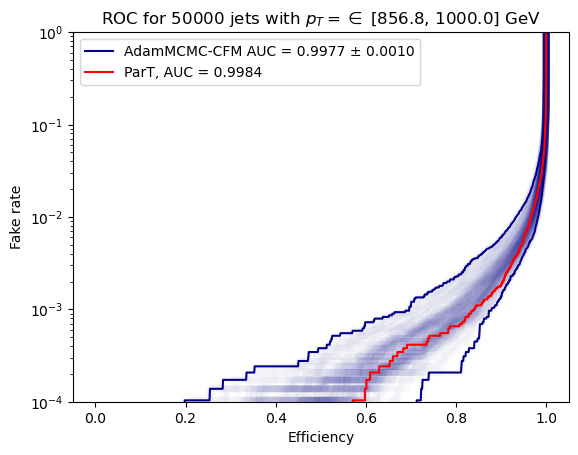

In [21]:
p_t_sorted = dataset_val.features[:,1][sort]*dataset_val.std_norm[:,1]+dataset_val.means_norm[:,1]

for start in [None, 200000, -100000, -n_points-1]:
    print('calculating:', start)
    save_str = 'x_gens'
    if start is not None:
        save_str += f'_{start}_{start+n_points}'
    
    with open(m_list_dir + save_str + '.npy', 'rb') as f:
        x_gens = np.load(f)
        
    _ = plt.hist(x_gens.flatten(), histtype = 'step')
    if start is not None:
        plt.title(f'outputs for {len(x_gens)} jets with $p_T= \in$ [{p_t_sorted[start]:.3}, {p_t_sorted[start+len(x_gens)]:.3}]')
    else:
        plt.title(f'outputs for {len(x_gens)} jets')
    plt.savefig(m_list_dir + save_str + '.pdf')
    plt.show()
    
    if start is None:
        x_true = dataset_val.truth[perm[:n_points]]
        fpr,tpr,t = roc_curve(x_true, dataset_val.raw_target[perm[:n_points]])
    else:
        x_true = dataset_val.truth[sort[start:start+n_points]]
        fpr,tpr,t = roc_curve(x_true, dataset_val.raw_target[sort[start:start+n_points]])

    try:
        with open(m_list_dir + save_str + '_fpr.npy', 'rb') as f:
            gfpr = np.load(f)
        with open(m_list_dir + save_str + '_tpr.npy', 'rb') as f:
            gtpr = np.load(f)

    except:
        gfpr, gtpr,_ = alea_roc_curve(x_true, x_gens, treshholds=t)

        with open(m_list_dir + save_str + '_fpr.npy', 'wb') as f:
             np.save(f, gfpr)
        with open(m_list_dir + save_str + '_tpr.npy', 'wb') as f:
             np.save(f, gtpr)
        
    aucs = []
    for i in range(gfpr.shape[1]):
        aucs.append(auc(gfpr[:,i], gtpr[:,i]))
    aucs = np.array(aucs)

    for i in range(n_stat_epis):
        plt.plot(gtpr[:,i], gfpr[:,i], color = 'darkblue', alpha  = 0.02, linewidth = 5)

    x_plot = np.linspace(1e-5,1-1e-5,1000)
    y_plot_max = np.array([np.max(gfpr[gtpr<x]) for x in x_plot])
    y_plot_min = np.array([np.min(gfpr[gtpr>1-x]) for x in x_plot])

    plt.plot(x_plot,y_plot_max, color = 'darkblue', label=f'AdamMCMC-CFM AUC = {aucs.mean():.4f} ± {aucs.std():.4f}')
    plt.plot(1-x_plot,y_plot_min, color = 'darkblue')

    plt.plot(tpr, fpr, label=f'ParT, AUC = {auc(fpr, tpr):.4f}',  color = 'red')

    plt.ylim(1e-4, 1)
    plt.xlabel("Efficiency")
    plt.ylabel("Fake rate")
    if start is not None:
        plt.title(f'ROC for {len(x_gens)} jets with $p_T= \in$ [{p_t_sorted[start]:4.1f}, {p_t_sorted[start+len(x_gens)]:4.1f}] GeV')
    else:
        plt.title(f'ROC for {len(x_gens)} jets')
    plt.legend()
    img_outfile = m_list_dir + save_str +f"_roc.pdf"
    plt.savefig(img_outfile)

    plt.yscale('log')
    img_outfile = m_list_dir + save_str+ f"_roc_log.pdf"
    plt.savefig(img_outfile)
    plt.show()